# Imports

In [ ]:
!pip install idx2numpy

  Created wheel for idx2numpy: filename=idx2numpy-1.2.2-cp36-none-any.whl size=8032 sha256=0bdcea5b774740613c498034e683f48a8696800f35e74739eb597a1e09e86304
  Stored in directory: /root/.cache/pip/wheels/7a/b5/69/3e0757b3086607e95db70661798fdf98a77a0bb79c54e1f320
Successfully built idx2numpy


In [2]:
import os
import math
import random
import torch
import itertools
import idx2numpy
import torchvision
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import torch.nn as nn
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib.gridspec import GridSpec
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')

# Data downloading

In [ ]:
!wget http://students.mimuw.edu.pl/~mf359257/data/train-labels-idx1-ubyte
!wget http://students.mimuw.edu.pl/~mf359257/data/train-images-idx3-ubyte
!wget http://students.mimuw.edu.pl/~mf359257/data/t10k-images-idx3-ubyte

--2020-01-16 07:54:25--  http://students.mimuw.edu.pl/~mf359257/data/train-labels-idx1-ubyte
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60008 (59K)
Saving to: ‘train-labels-idx1-ubyte’

train-labels-idx1-u 100%[===================>]  58.60K   245KB/s    in 0.2s    

2020-01-16 07:54:26 (245 KB/s) - ‘train-labels-idx1-ubyte’ saved [60008/60008]

--2020-01-16 07:54:27--  http://students.mimuw.edu.pl/~mf359257/data/train-images-idx3-ubyte
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47040016 (45M)
Saving to: ‘train-images-idx3-ubyte’

train-images-idx3-u 100%[===================>]  44.86M  7.07MB/s    in 7.0

# Data loading
Dividing X_train and X_test by 255 to transform values into [0, 1] range

In [3]:
def load(path):
    return idx2numpy.convert_from_file(path)

X, y = load('train-images-idx3-ubyte') / 255, load('train-labels-idx1-ubyte')
X_test = load('t10k-images-idx3-ubyte') / 255
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1)

# Data info

In [ ]:
print("Data shapes:")
print(f"X_train {X_train.shape}")
print(f"X_val   {X_val.shape}")
print(f"X_test  {X_test.shape}")
_, counts = np.unique(y, return_counts=True)
print(f"Class counts in training set: {counts}")

Data shapes:
X_train (54000, 28, 28)
X_val   (6000, 28, 28)
X_test  (10000, 28, 28)
Class counts in training set: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


# Data examples

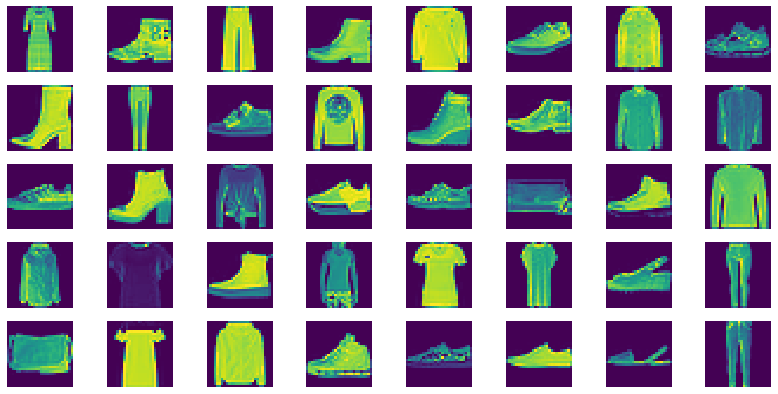

In [ ]:
fig = plt.figure(figsize=(14, 7))
NROWS, NCOLS = 5, 8
gs = GridSpec(nrows=NROWS, ncols=NCOLS)
for i in range(NROWS):
    for j in range(NCOLS):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(X_train[i*NCOLS+j])
        plt.axis('off')
plt.axis('off')
plt.show()

# Preparing data

1. Normalizing data

2. Augmenting data during training:
    - Random cropping
    - Random horizontal flip
    - Random erasing

In [4]:
MEAN, STD = round(np.mean(X_train), 5), round(np.std(X_train), 5)

train_transform = transforms.Compose([transforms.RandomCrop(28, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.RandomErasing(),
                                      transforms.Normalize((MEAN,), (STD,))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((MEAN,), (STD,))])

class FashionDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        X = self.transform(Image.fromarray(self.X[index]))
        if self.y is None:
            return X
        return X, self.y[index]
        
def fetchDataLoader(X, y, transform=None, batch_size=256, shuffle=True, num_workers=8):
    dataset = FashionDataset(X, y, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return dataloader

trainLoader = fetchDataLoader(X_train, y_train, train_transform)
valLoader = fetchDataLoader(X_val, y_val, test_transform, shuffle=False)
testLoader = fetchDataLoader(X_test, y=None, transform=test_transform, shuffle=False)

# Example of data augmentation
On the left side original image, on the right side augmented image

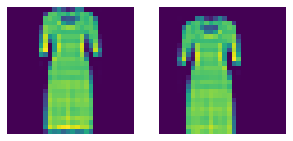

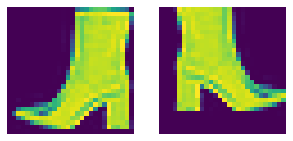

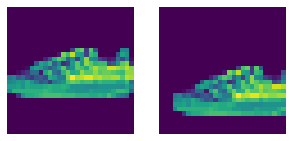

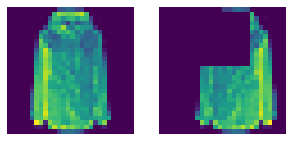

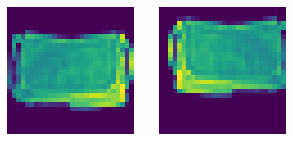

In [ ]:
gs = GridSpec(nrows=1, ncols=2)
for i in range(5):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(X_train[i*NCOLS])
    plt.axis('off')
    ax = fig.add_subplot(gs[0, 1])
    ax.imshow(train_transform(Image.fromarray(X_train[i*NCOLS])).squeeze())
    plt.axis('off')
    plt.show()

# ResNet18 and ResNet34
Modyfing a little resnet architecture by:
- removing last block i.e layer4
- removing max pooling before layer1

In [5]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

# Util funtions

In [6]:
def train_epoch(loader=trainLoader):
    total_tr, correct_tr = 0, 0
    loss_tr = []
    model.train()
    
    for X, y_true in loader:
        optimizer.zero_grad()            
        X, y_true = X.to(device), y_true.type(torch.LongTensor).to(device)
        y_pred = model(X.float())
        loss = loss_fn(y_pred, y_true)
        loss_tr.append(loss.item())
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_pred.data, 1)
        total_tr += y_true.shape[0]
        correct_tr += (predicted == y_true).sum().item()
    return np.mean(loss_tr), 100*correct_tr/total_tr

def evaluate():        
    model.eval()
    preds, loss_val = [], []
    total_val, correct_val = 0, 0
    with torch.no_grad():
        for X, y_true in valLoader:
            X, y_true = X.to(device), y_true.type(torch.LongTensor).to(device)
            y_pred = model(X.float())
            loss = loss_fn(y_pred, y_true)
            loss_val.append(loss.item())

            _, predicted = torch.max(y_pred.data, 1)
            total_val += y_true.shape[0]
            correct_val += (predicted == y_true).sum().item()
            preds.append(predicted)
    preds = [item.item() for sublist in preds for item in sublist]
    return np.mean(loss_val), 100*correct_val/total_val, preds

def predict(model):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in testLoader:
            X = X.to(device)
            y_pred = model(X.float())
            _, predicted = torch.max(y_pred.data, 1)
            preds.append(predicted)
    preds = [item.item() for sublist in preds for item in sublist]
    return preds

def train_and_evaluate(epochs, name):
    best_acc, snapshots = 0.0, 0
    history = {}
    history['train_loss'], history['val_loss'], history['train_acc'], history['val_acc'] = [], [], [], []

    for epoch in range(epochs):
        tr_loss, tr_acc = train_epoch()
        val_loss, val_acc, preds = evaluate()
        history['train_loss'].append(tr_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(tr_acc)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch: [{epoch+1}/{epochs}] loss: {tr_loss:.4f} - acc: {tr_acc:.4f} - val_loss: {val_loss:.4f} - val_acc {val_acc:.4f}")
        if best_acc < val_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{name}.pth")
        if val_acc >= 95.4:
             torch.save(model.state_dict(), f"{name}_{snapshots}.pth")
             snapshots += 1
        scheduler.step()
    return history

def plot_metrics(train, val, title, loc='lower'):
    plt.figure(figsize=(8,5))
    plt.plot(train, 'dodgerblue', label='training')
    plt.plot(val, 'darkorange', label='validation')
    plt.title(title, fontsize=20)
    if loc == 'lower':
        plt.legend(loc='lower right', prop={'size': 15})
    else:
        plt.legend(loc='upper right', prop={'size': 15})
    plt.show()
    
def vis_training(history):
    plot_metrics(history['train_acc'], history['val_acc'], 'Accuracy')
    plot_metrics(history['train_loss'], history['val_loss'], 'Loss', 'upper')
    
def prepare_submit(name):
    snapshots = glob(f"{name}_*")
    y_pred = []
    if name == 'ResNet18':
        model = resnet18().to(device)
    else:
        model = resnet34().to(device)

    # generating predictions for each snapshot 
    for snap in snapshots:
        model.load_state_dict(torch.load(snap))
        preds = predict(model)
        y_pred.append(preds)

    # voting
    y_final = []
    for idx in range(len(y_pred[0])): 
        preds = []
        for list_idx in range(len(y_pred)):
            preds.append(y_pred[list_idx][idx])
        y_final.append(Counter(preds).most_common(1)[0][0])

    pd.DataFrame({'Id': range(len(y_final)), 'Class': y_final}).to_csv(f"{name}.csv", index=False)
    
def train(epochs, name):
    history = train_and_evaluate(epochs, name)
    snapshots = glob(f"{name}_*")
    for i, snap in enumerate(snapshots):
        print(f"[{i+1}/{len(snapshots)}] Training ov validation {snap}")
        model.load_state_dict(torch.load(snap))
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, valid_epochs, eta_min=1e-7)
        # training on validation set with small learning rate
        for epoch in range(valid_epochs):
            tr_loss, tr_acc = train_epoch(valLoader)
            print(f"Epoch: [{epoch+1}/{valid_epochs}] loss: {tr_loss:.4f} - acc: {tr_acc:.4f}")
        torch.save(model.state_dict(), snap)
    vis_training(history)
    
def set_seed():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic=True

valid_epochs = 5
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Training model
Ensambling strategy: creating snapshots for models acheiving more than 95% accuracy on validation set retraining them on validation set and voting on test set.

Epoch: [1/80] loss: 0.6908 - acc: 74.7185 - val_loss: 0.5340 - val_acc 80.3667
Epoch: [2/80] loss: 0.4336 - acc: 84.1574 - val_loss: 0.3359 - val_acc 87.8833
Epoch: [3/80] loss: 0.3748 - acc: 86.3370 - val_loss: 0.2919 - val_acc 89.3333
Epoch: [4/80] loss: 0.3427 - acc: 87.5407 - val_loss: 0.3186 - val_acc 88.8833
Epoch: [5/80] loss: 0.3241 - acc: 88.1130 - val_loss: 0.3378 - val_acc 88.2500
Epoch: [6/80] loss: 0.3059 - acc: 88.8037 - val_loss: 0.3059 - val_acc 88.7667
Epoch: [7/80] loss: 0.2904 - acc: 89.3852 - val_loss: 0.3080 - val_acc 88.7500
Epoch: [8/80] loss: 0.2850 - acc: 89.4722 - val_loss: 0.3279 - val_acc 88.4667
Epoch: [9/80] loss: 0.2726 - acc: 89.8963 - val_loss: 0.3367 - val_acc 88.1667
Epoch: [10/80] loss: 0.2624 - acc: 90.4019 - val_loss: 0.2582 - val_acc 91.0167
Epoch: [11/80] loss: 0.2568 - acc: 90.5648 - val_loss: 0.2050 - val_acc 92.7000
Epoch: [12/80] loss: 0.2505 - acc: 90.8019 - val_loss: 0.2172 - val_acc 92.2500
Epoch: [13/80] loss: 0.2399 - acc: 91.2574 - val_

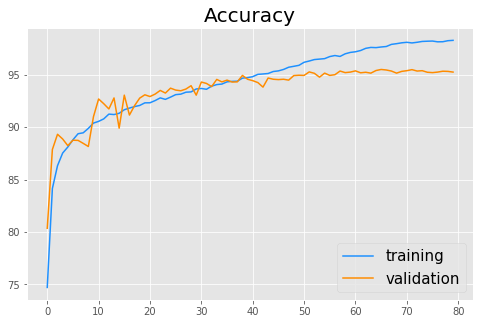

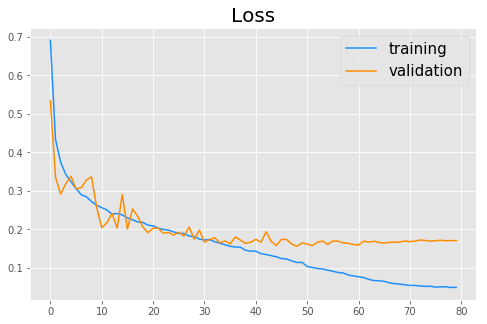

In [7]:
set_seed()
epochs = 80
model = resnet18().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-7)
loss_fn = torch.nn.CrossEntropyLoss()
train(epochs=epochs, name="ResNet18")
prepare_submit("ResNet18")

Epoch: [1/100] loss: 0.6954 - acc: 74.4519 - val_loss: 0.4828 - val_acc 81.5167
Epoch: [2/100] loss: 0.4255 - acc: 84.4370 - val_loss: 0.4182 - val_acc 84.3167
Epoch: [3/100] loss: 0.3630 - acc: 86.5852 - val_loss: 0.3775 - val_acc 86.5667
Epoch: [4/100] loss: 0.3281 - acc: 87.9778 - val_loss: 0.2626 - val_acc 90.3000
Epoch: [5/100] loss: 0.3076 - acc: 88.8463 - val_loss: 0.3703 - val_acc 87.3833
Epoch: [6/100] loss: 0.2970 - acc: 89.0093 - val_loss: 0.3362 - val_acc 88.7000
Epoch: [7/100] loss: 0.2864 - acc: 89.5278 - val_loss: 0.4190 - val_acc 86.2833
Epoch: [8/100] loss: 0.2755 - acc: 89.9241 - val_loss: 0.2366 - val_acc 91.5167
Epoch: [9/100] loss: 0.2699 - acc: 90.0204 - val_loss: 0.2596 - val_acc 90.9500
Epoch: [10/100] loss: 0.2630 - acc: 90.2481 - val_loss: 0.2447 - val_acc 91.2833
Epoch: [11/100] loss: 0.2575 - acc: 90.6167 - val_loss: 0.2195 - val_acc 92.1667
Epoch: [12/100] loss: 0.2508 - acc: 90.7389 - val_loss: 0.2524 - val_acc 91.3000
Epoch: [13/100] loss: 0.2500 - acc: 9

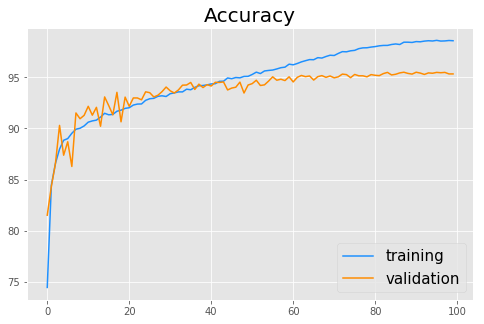

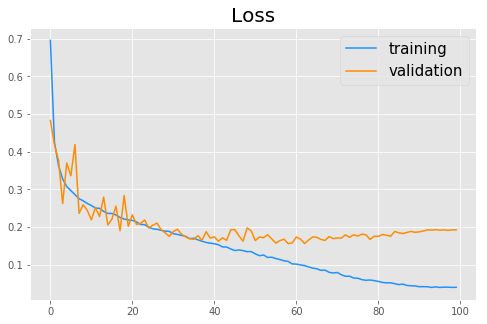

In [8]:
set_seed()
epochs=100
model = resnet34().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-7)
loss_fn = torch.nn.CrossEntropyLoss()
train(epochs, "ResNet34")
prepare_submit("ResNet34")